In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [4]:
# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)
SNR_linear = 10**(SNR_dB / 10)
h_u1_2, h_u2_2, h_oma_2 = 0.65, 2.7, 0.6
alpha1, alpha2 = 0.8, 0.2
Ns, sigma_n2, alpha_cyclic = 50, 1.0, 0.1
Pf_u1 = Pf_u2 = Pf_oma = 0.10
M1 = M2 = 2
num_samples = 10000
test_size = 0.2

In [5]:
# ---------------------
# 2) Cyclic Correlation Detection
# ---------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))


In [6]:
# ---------------------
# 3) ML Classifiers
# ---------------------
def generate_ml_data(snr_lin, num_samples):
    X, y = [], []
    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5
        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)
        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise
        mag, phase = np.abs(received), np.angle(received)
        features = [
            np.mean(mag), np.std(mag), np.max(mag), np.min(mag),
            np.mean(phase), np.std(phase),
            np.sum(mag**2),
            np.percentile(mag, 25), np.percentile(mag, 75),
            np.mean(np.diff(mag))
        ]
        X.append(features)
        y.append(signal_present)
    return np.array(X), np.array(y)

def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        results[name] = (fpr, tpr, roc_auc)
    return results

In [7]:
# ---------------------
# 4) Throughput Calculation
# ---------------------
def calc_noma_rate_user(alpha, h_2, snr, interference_alpha, interference_h_2):
    numerator = alpha * h_2 * snr
    denominator = (interference_alpha * interference_h_2 * snr + sigma_n2)
    return np.log2(1 + numerator / denominator)

def calc_oma_rate(h_oma_2, snr):
    return 0.5 * np.log2(1 + (h_oma_2 * snr) / sigma_n2)

In [8]:

# ---------------------
# 5) Simulation Loop
# ---------------------
results_dict = {
    'Pd_u1': [], 'Pd_u2': [], 'Pd_oma': [],
    'Pd_rf': [], 'Pd_lr': [], 'Pd_dt': [],
    'th_noma_u1': [], 'th_noma_u2': [], 'th_noma_total': [],
    'th_oma': [], 'th_noma_rf': [], 'th_noma_lr': [], 'th_noma_dt': []
}

for snr_db, snr_lin in zip(SNR_dB, SNR_linear):
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)

    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2, alpha_cyclic)

    X, y = generate_ml_data(snr_lin, num_samples)
    results = train_classifiers(X, y)
    fpr_target = 0.10
    pd_results = {
        name: float(interp1d(fpr, tpr)(fpr_target)) if max(fpr) >= fpr_target else 1.0
        for name, (fpr, tpr, _) in results.items()
    }

    rate_u1 = calc_noma_rate_user(alpha1, h_u1_2, snr_lin, alpha2, h_u2_2)
    rate_u2 = calc_noma_rate_user(alpha2, h_u2_2, snr_lin, 0, 0)
    rate_oma = calc_oma_rate(h_oma_2, snr_lin)

    results_dict['Pd_u1'].append(pd_u1)
    results_dict['Pd_u2'].append(pd_u2)
    results_dict['Pd_oma'].append(pd_oma)
    results_dict['Pd_rf'].append(pd_results['Random Forest'])
    results_dict['Pd_lr'].append(pd_results['Logistic Regression'])
    results_dict['Pd_dt'].append(pd_results['Decision Tree'])

    results_dict['th_noma_u1'].append(pd_u1 * rate_u1)
    results_dict['th_noma_u2'].append(pd_u2 * rate_u2)
    results_dict['th_noma_total'].append(pd_u1 * rate_u1 + pd_u2 * rate_u2)
    results_dict['th_oma'].append(pd_oma * rate_oma)
    results_dict['th_noma_rf'].append(pd_results['Random Forest'] * (rate_u1 + rate_u2))
    results_dict['th_noma_lr'].append(pd_results['Logistic Regression'] * (rate_u1 + rate_u2))
    results_dict['th_noma_dt'].append(pd_results['Decision Tree'] * (rate_u1 + rate_u2))

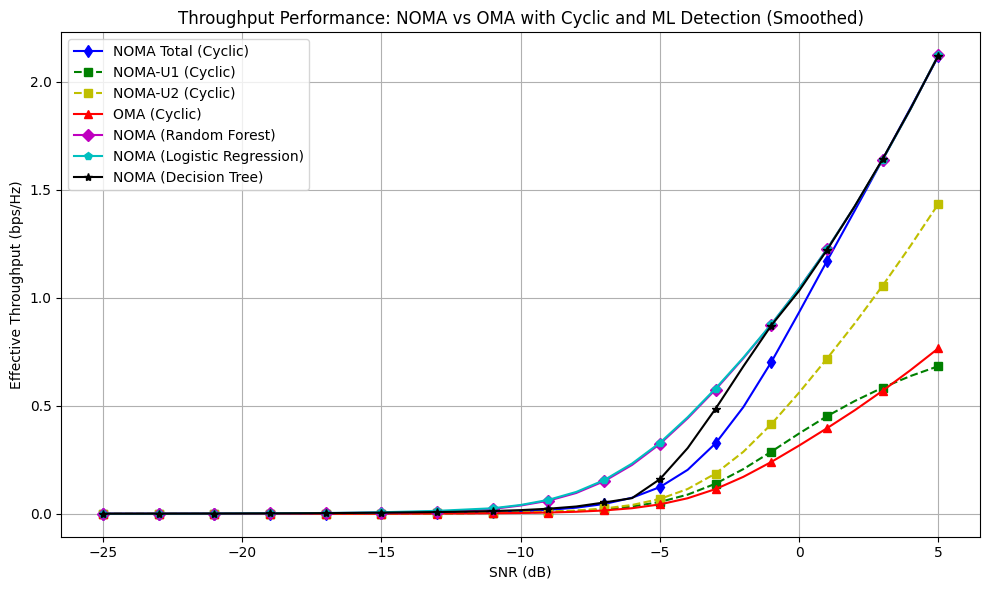

In [9]:
# ---------------------
# 6) Smooth and Plot
# ---------------------
window_length, polyorder = 7, 2
smoothed_curves = {
    key: savgol_filter(results_dict[key], window_length, polyorder)
    for key in results_dict if key.startswith('th_')
}

plt.figure(figsize=(10, 6))
plt.plot(SNR_dB, smoothed_curves['th_noma_total'], 'b-d', label='NOMA Total (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_u1'], 'g--s', label='NOMA-U1 (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_u2'], 'y--s', label='NOMA-U2 (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_oma'], 'r-^', label='OMA (Cyclic)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_rf'], 'm-D', label='NOMA (Random Forest)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_lr'], 'c-p', label='NOMA (Logistic Regression)', markevery=2)
plt.plot(SNR_dB, smoothed_curves['th_noma_dt'], 'k-*', label='NOMA (Decision Tree)', markevery=2)

plt.xlabel('SNR (dB)')
plt.ylabel('Effective Throughput (bps/Hz)')
plt.title('Throughput Performance: NOMA vs OMA with Cyclic and ML Detection (Smoothed)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('noma_oma_ml_throughput_comparison_smooth.png', dpi=300)
plt.show()

In [10]:
# ---------------------
# 7) Print 0 dB Analysis
# ---------------------
idx_0dB = np.where(SNR_dB == 0)[0][0]
print("\nThroughput at SNR = 0 dB (Original Data):")
print(f"NOMA U1 (Cyclic): {results_dict['th_noma_u1'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA U2 (Cyclic): {results_dict['th_noma_u2'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic): {results_dict['th_noma_total'][idx_0dB]:.4f} bps/Hz")
print(f"OMA (Cyclic): {results_dict['th_oma'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Random Forest): {results_dict['th_noma_rf'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Logistic Regression): {results_dict['th_noma_lr'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA (Decision Tree): {results_dict['th_noma_dt'][idx_0dB]:.4f} bps/Hz")
print(f"NOMA Total (Cyclic)/OMA Ratio: {results_dict['th_noma_total'][idx_0dB] / results_dict['th_oma'][idx_0dB]:.4f}")



Throughput at SNR = 0 dB (Original Data):
NOMA U1 (Cyclic): 0.3736 bps/Hz
NOMA U2 (Cyclic): 0.5629 bps/Hz
NOMA Total (Cyclic): 0.9365 bps/Hz
OMA (Cyclic): 0.3172 bps/Hz
NOMA (Random Forest): 1.0426 bps/Hz
NOMA (Logistic Regression): 1.0426 bps/Hz
NOMA (Decision Tree): 1.0327 bps/Hz
NOMA Total (Cyclic)/OMA Ratio: 2.9522


SNR = -25 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.089, LR-Pd = 0.093, DT-Pd = 0.110

SNR = -24 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.087, LR-Pd = 0.096, DT-Pd = 0.103

SNR = -23 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.107, LR-Pd = 0.107, DT-Pd = 0.098

SNR = -22 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.092, LR-Pd = 0.106, DT-Pd = 0.099

SNR = -21 dB | U1-Pd = 0.038 | U2-Pd = 0.038 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.086, LR-Pd = 0.128, DT-Pd = 0.098

SNR = -20 dB | U1-Pd = 0.039 | U2-Pd = 0.039 | OMA-Pd = 0.038
ML Results: RF-Pd = 0.117, LR-Pd = 0.097, DT-Pd = 0.099

SNR = -19 dB | U1-Pd = 0.040 | U2-Pd = 0.040 | OMA-Pd = 0.039
ML Results: RF-Pd = 0.106, LR-Pd = 0.099, DT-Pd = 0.103

SNR = -18 dB | U1-Pd = 0.041 | U2-Pd = 0.041 | OMA-Pd = 0.040
ML Results: RF-Pd = 0.119, LR-Pd = 0.139, DT-Pd = 0.107

SNR = -17 dB | U1-Pd = 0.043 | U2-Pd = 0.043 | O

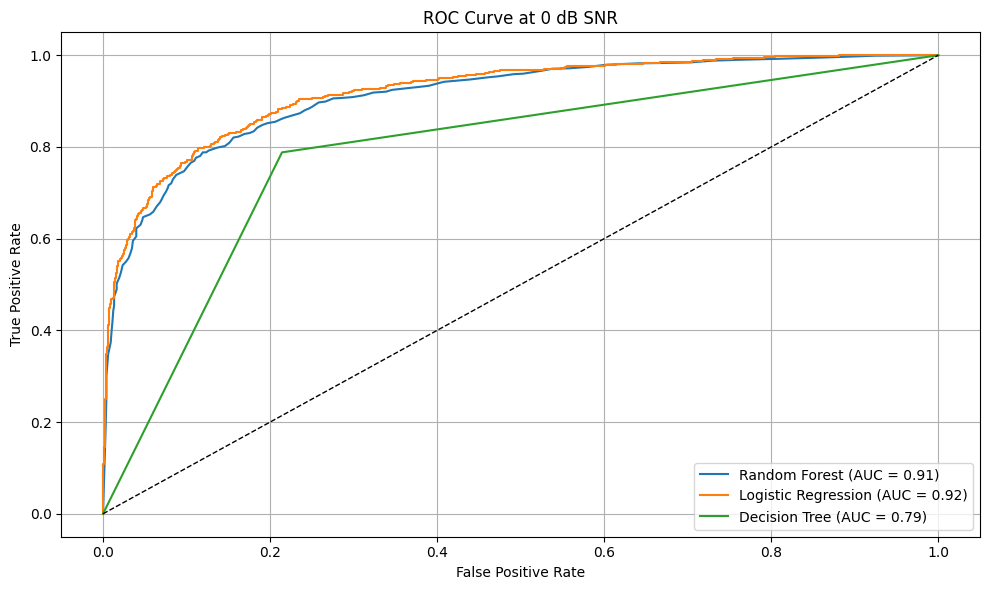

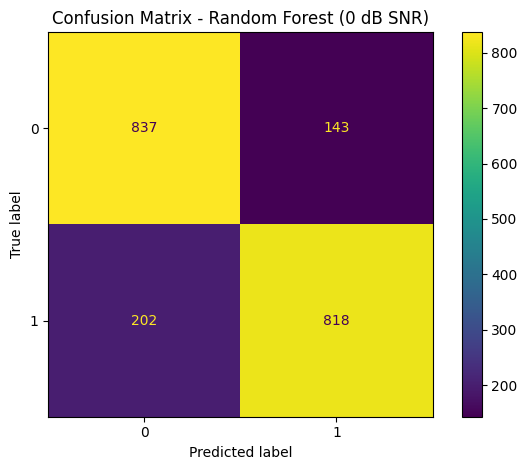

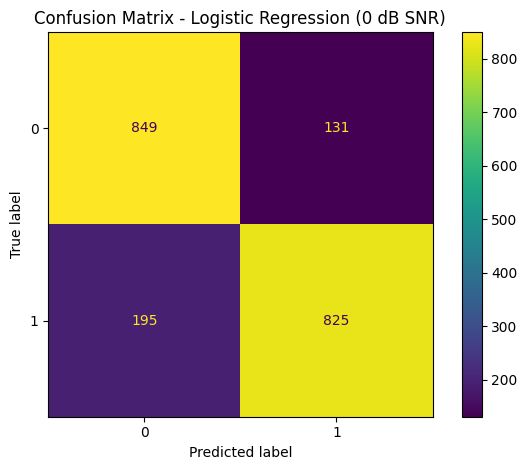

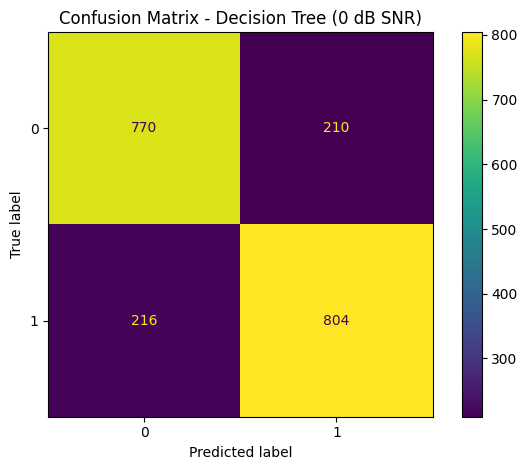